In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

I came accross this dataset while working on a Corona X-Ray dataset. Here is the link to the Corona X-ray dataset [dataset link](https://github.com/ieee8023/covid-chestxray-dataset). As this dataset has less images already I needed some normal X-ray images so I used the normal directory images in the Corona project. 

Now the link to is  [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). 

I am using Google Colab to run this so I have uploaded the dataset on Google Drive. 

In [0]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline



In [0]:
total_images_train_normal = os.listdir('/content/gdrive/My Drive/chest_xray/test/NORMAL')
total_images_train_pneumonia = os.listdir('/content/gdrive/My Drive/chest_xray/test/PNEUMONIA/')

Just imported the essential packages and passed the dataset path upto now.

In [0]:
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/content/gdrive/My Drive/chest_xray/test/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

In [0]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/content/gdrive/My Drive/chest_xray/test/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

These are The **Normal** and **Pneumonia** X-Ray Images. 

In [0]:
sns.set_style('dark')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

The training data is mildly in favor of the Pneumonia side with almost 100 more images for Pneumonia. To think about it , will evenly distributing the images improve accuracy of model? I think **NO**. As for normal images it was pretty much the same for each image. There should be more of a variety for Pneumonia cases. 

That being said 350 images for training set is less regardless. Let's perform data Augmentatation of the data.

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
training_set = train_datagen.flow_from_directory('/content/gdrive/My Drive/chest_xray/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')



Found 5224 images belonging to 2 classes.


In [38]:
test_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/chest_xray/test',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='binary')


val_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/chest_xray/val',
                                            target_size=(image_width, image_height),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary')



Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [40]:
print(len(test_set))

78


In [0]:
image_height = 150
image_width = 150
batch_size = 8
no_of_epochs  = 15

Declared the various variables that we are going to need over for the next steps. 

In [0]:


model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 34, 34, 64)       

To make sure that the model keeps on learning lets add a callback function.

In [0]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

print(len(training_set))


In [41]:
history = model.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=callbacks
                   )

Epoch 1/15
652/652 [==============================] - 829s 1s/step - loss: 0.4761 - acc: 0.7860 - val_loss: 0.6090 - val_acc: 0.7628
Epoch 2/15
652/652 [==============================] - 777s 1s/step - loss: 0.2808 - acc: 0.8811 - val_loss: 0.3520 - val_acc: 0.8413
Epoch 3/15
652/652 [==============================] - 775s 1s/step - loss: 0.2462 - acc: 0.8980 - val_loss: 0.4254 - val_acc: 0.8061
Epoch 4/15
652/652 [==============================] - 782s 1s/step - loss: 0.2110 - acc: 0.9199 - val_loss: 0.3267 - val_acc: 0.8606
Epoch 5/15
652/652 [==============================] - 781s 1s/step - loss: 0.1937 - acc: 0.9225 - val_loss: 0.4644 - val_acc: 0.8285
Epoch 6/15
652/652 [==============================] - 779s 1s/step - loss: 0.1861 - acc: 0.9287 - val_loss: 0.3813 - val_acc: 0.8349
Epoch 7/15
652/652 [==============================] - 779s 1s/step - loss: 0.1692 - acc: 0.9387 - val_loss: 0.4365 - val_acc: 0.8974
Epoch 8/15
652/652 [==============================] - 782s 1s/step - 

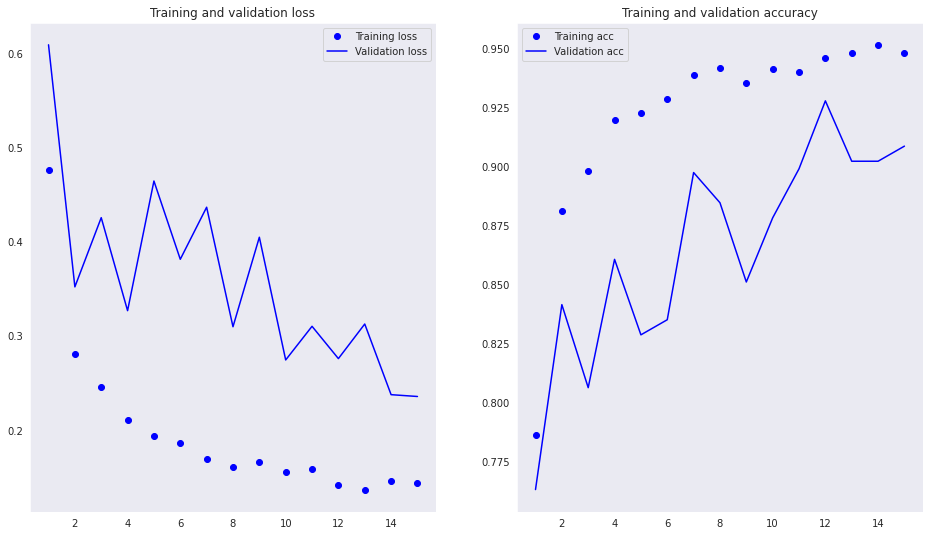

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [0]:
model.save("pneumonia95%.h5")